In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra

In [2]:
# Squared-exponential covariance function
sqexp_cov_fn(D, phi) = @. exp(-D^2 / (2*phi)) 
# Exponential covariance function
exp_cov_fn(D, phi) = @. exp(-D / phi)
# Exponential covariance function
sqexp_cov_fn2(D, n, l, eps=1e-1) = @.(n*exp(-D^2/(2*l))) + LinearAlgebra.I * eps

sqexp_cov_fn2 (generic function with 2 methods)

In [3]:
@model function marginal_GP(y, X, m=0, s=1, cov_fn=sqexp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    
    # Realized covariance function
    K = cov_fn(D, phi)
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end

marginal_GP (generic function with 5 methods)

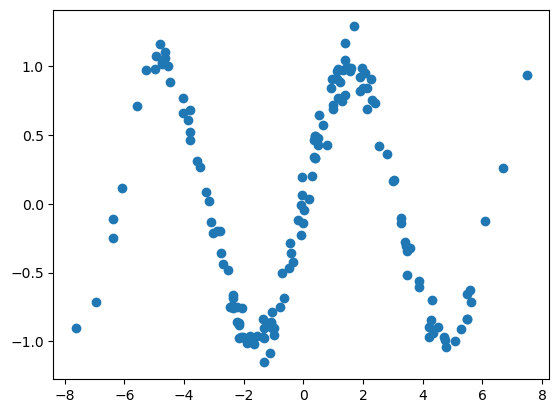

PyObject <matplotlib.collections.PathCollection object at 0x7fd3163da5e0>

In [4]:
N = 150
X = randn(N, 1) * 3
y = sin.(vec(X)) + randn(N) * 0.1
plt.scatter(vec(X), y)

In [5]:
chain = sample(marginal_GP(y, X), HMC(0.01, 100), 200)

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:36


Chains MCMC chain (200×12×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
Wall duration     = 109.68 seconds
Compute duration  = 109.68 seconds
parameters        = mu, sig2, phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          mu    0.0081    0.4217     0.0298    0.0143   1853.8619    0.9951    ⋯
        sig2    1.0101    0.5041     0.0356    0.1300      1.6174    1.6416    ⋯
         phi    3.2106    2.2541     0.1594    0.1111    668.3634    1.0051    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   F

In [6]:
mu = group(chain, :mu).value.data[:, :, 1]
sig2 = group(chain, :sig2).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1];

In [7]:
function make_gp_predict_fn(Xnew, y, X, cov_fn)
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    
    return (mu, sig2, phi) -> let
        K = cov_fn(D, phi) + sig2 * LinearAlgebra.I
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y .- mu) .+ mu
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 1 method)

In [8]:
Xnew = sort(randn(N, 1) * 4, dims=1)
gp_predict = make_gp_predict_fn(Xnew, y, X, sqexp_cov_fn)
ynew = [gp_predict(mu[m], sig2[m], phi[m]) for m in 1:length(mu)]
ynew = hcat(ynew...);

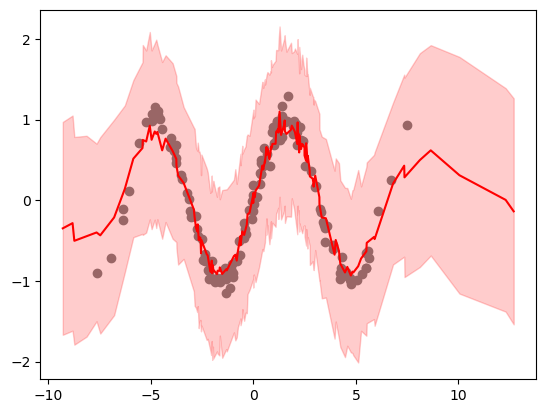

In [9]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2)

plt.plot(vec(Xnew), vec(pred_mean), color="red", label="Posterior predictive mean")
plt.scatter(vec(X), vec(y), color="grey", label="Data")
plt.fill_between(vec(Xnew), vec(pred_mean .+ pred_std), vec(pred_mean .- pred_std), color="red", alpha=0.2)
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");